In [34]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional,Flatten,Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [35]:
def remove_special_chars(tweets): # it unrolls the hashtags to normal words
    for remove in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
    "@", "%", "^", "*", "(", ")", "{", "}",
    "[", "]", "|", "/", "\\", ">", "<", "-",
    "!", "?", ".", "‘",
    " — ", " — -", "#"]):
      tweets.replace(remove, "", inplace=True)
    return tweets
def remove_tags(text):
  return re.compile(r'<[^>]+>').sub('', text)
def remove_num(text):
  return ''.join(re.sub(r"([0–9]+)","",text))
data = pd.read_csv('drive/MyDrive/ML Projects/Sentiment Analysis/IMDB Dataset.csv')
data = data[:2500]
data.review=data.review.apply(lambda x : remove_tags(x))
data.review=data.review.apply(lambda x : remove_num(x))
remove_special_chars(data.review)
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,Petter Mattei's Love in the Time of Money is a...,positive
...,...,...
2495,Another great movie by CostaGavras It's a grea...,negative
2496,Though structured totally different from the b...,positive
2497,Handsome and dashing British airline pilot Geo...,positive
2498,This film breeches the fine line between satir...,negative


In [36]:
tokenizer = Tokenizer(num_words=5000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
tokenizer.fit_on_texts(data['review'])
X = tokenizer.texts_to_sequences(data['review'])
X = pad_sequences(X,maxlen=500)
Y = data['sentiment']
vocab_size = len(tokenizer.word_index) + 1
# We can then create our train and test sets:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 24)
#We store this tokenizer in a file to use later in web app
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
from sklearn.preprocessing import LabelEncoder
def prepare_targets(y_train, y_test):
 le = LabelEncoder()
 le.fit(y_train)
 y_train_enc = le.transform(y_train)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc
ytrain,ytest = prepare_targets(Y_train,Y_test)

In [37]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=50))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 50)            1876150   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               183296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,059,703
Trainable params: 2,059,703
Non-trainable params: 0
_________________________________________________________________


In [41]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history=model.fit(X_train, ytrain,
 batch_size=287,
 epochs=10,
 validation_data=[X_test, ytest],
 callbacks=[es])
#We save this model so that we can use in own web app
model.save('drive/My Drive/Dog Vision/models/movie_sent.h5')

Epoch 1/10
7/7 [==============================] - 1s 134ms/step - loss: 0.6618 - accuracy: 0.6194 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 1s 126ms/step - loss: 0.7311 - accuracy: 0.6543 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 1s 126ms/step - loss: 0.6243 - accuracy: 0.6411 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
7/7 [==============================] - 1s 125ms/step - loss: 0.5725 - accuracy: 0.7994 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
7/7 [==============================] - 1s 125ms/step - loss: 0.4514 - accuracy: 0.8417 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
7/7 [==============================] - 1s 125ms/step - loss: 0.4018 - accuracy: 0.8686 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 00006: early stopping


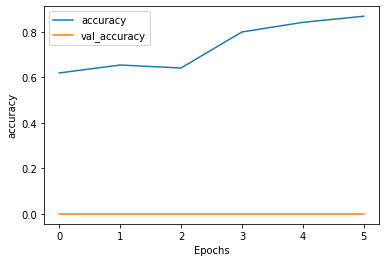

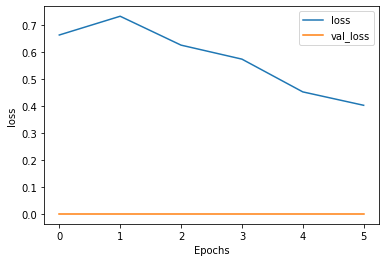

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [43]:
string11='''Between the Lovecraftian overtones and Liberato’s performance, 
The Beach House offers up beautifully shot terror and will make you think before opening your door.'''
x_1=tokenizer.texts_to_sequences([string11])
x_1 = pad_sequences(x_1,maxlen=500)
model.predict(x_1)

array([[0.59378153]], dtype=float32)